### Characterizing bursting dynamics of links

In order to charaterize the bursting dynamics of the links in the temporal network (see Notebook 4) the methods in __GDa.stats.bursting__ module can be used. 

In particular, we do so for binary arrays of activations that, similar to  spike-trains, are binary with the value one used to represent the activation of a certain link. For each activation sequence we characterize the following statistics: link avg. activation time (mu), total act. time relative to task stage time (mu_tot), CV (mean activation time over its std).

This procedure requires that we threshold the values of coherence in the temporal network. The thresholds are defined for each link (relative) or commonly for all links (absolute) based on a arbritary quartile of its coherence distribution __q__. Since this thresholding procedure can affect the results we also study how the threshold level influnces the statistics measured. It is also important to note that since we may compare different trial types (ODRT, int. fixation, blocked fixation) the threshold is computed commonly for all the trials.

Analysis of the burst dynamics of each link for each frequency band and stage of the ODRT.

- Recompute supertensor with novel and better multi-taper approach and bands of reference without leakage (then show a plot of how a piece of this supertensor looks like) **(x)**
- Plot the "ERP don't exist" figures as in the slide here below **(x)**
- Plot a binarized raster for a threshold of reference, common between task and fixation trials **(x)**
- Extracts link activation events (measured in ms) taking care of not crossing trial boundaries prior to concatenating all trials together **(x)**
- Compute concatenated trial distributions of: i) link activation time (in ms); ii) total activation time (relative to total time in task stage across all trials); and, iii) CV for the reference threshold **(x)**
- Track how the peaks (e.g. median) and widths (e.g. interquartile range) of these distributions vary as a function of changing threshold **(x)**
- Compute joint distribution of pairs formed of the quantities i-iii above plus also link length (measured along white matter tract if possible) 
- Plot the baseline surface of these distributions and the relative variation with baseline for the other task stages
- Plot the variations between fixation and task trials joint distributions above
- Compute meta-connectivity...
- Plot how modularity and average of MC change as a function of threshold
- Compute multiplex meta-connectivity as well, where sync is between a link in one layer and a link in another layer, not just within layer

In [1]:
# Adding GDa to path
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
# Importing the temporal network class
from   GDa.temporal_network              import temporal_network
from   xfrites.conn.conn_coh             import conn_coherence_wav

from   tqdm                              import tqdm
from   GDa.graphics.plot_brain_sketch    import *
from   GDa.session                       import session
from   sklearn.manifold                  import TSNE
from   scipy                             import stats

import GDa.stats.bursting       as       bst
import seaborn                  as       sns
import numpy                    as       np
import xarray                   as       xr
import matplotlib.pyplot        as       plt
import scipy.signal
import time
import os
import h5py

In [2]:
# Auxiliary function to smooth
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

# Bands names
band_names  = [r'band 1', r'band 2', r'band 3', r'band 4', r'band 5']
stages      = ['baseline', 'cue', 'delay', 'match']

### Loading session

In [3]:
# Parameters to read the data
idx      = 3 
nses     = 1
nmonkey  = 0
align_to = 'cue'

dirs = { 'rawdata':'/home/vinicius/GrayData-Analysis/GrayLab/',
         'results':'Results/',
         'monkey' :['lucy', 'ethyl'],
         'session':'session01',
         'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []] }

In [4]:
#  Instantiating session
ses   = session(raw_path = dirs['rawdata'], monkey = dirs['monkey'][nmonkey], date = dirs['date'][nmonkey][idx],
                session = nses, slvr_msmod = False, align_to = align_to, evt_dt = [-0.65, 3.00])
# Load data
ses.read_from_mat()

### Coherence computation

In [5]:
# Defining parameters
f_start, f_end, n_freqs, sfreq = .1, 80, 50, ses.data.attrs['fsample']
freqs = np.linspace(f_start, f_end, n_freqs, endpoint=True)
delta = 15 # Downsampling factor
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
if mode in ["morlet", "mt_1"]:
    foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])
    n_cycles     = freqs/2
    mt_bandwidth = None
    decim_at='tfd'
elif mode is "mt_2":
    foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])
    freqs = foi.mean(axis=1)
    W     = np.ceil( foi[:,1]-foi[:,0] )   # Bandwidth
    foi   = None     
    n_cycles     = np.array([3, 5, 9, 12, 16])
    mt_bandwidth = np.array([2, 4, 4.28, 5.647, 9.65])
    decim_at     = 'coh'

In [6]:
kw = dict(
    freqs=freqs, times=ses.data.time, roi=ses.data.roi, foi=foi, n_jobs=-1,
    sfreq=sfreq, mode=mode, decim_at=decim_at, n_cycles=n_cycles, decim=delta,
    sm_times=300, sm_freqs=1, block_size=2
)

# compute the coherence
coh = conn_coherence_wav(ses.data.values.astype(np.float32), **kw)

Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   11.2s remaining:   16.3s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   12.7s remaining:    8.1s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   14.1s remaining:    3.2s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   15.5s finished


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   18.5s remaining:   26.8s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   20.3s remaining:   12.9s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   21.8s remaining:    4.9s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   23.4s finished


In [7]:
path_st = os.path.join('data', 
          dirs['monkey'][nmonkey] + '_session01_' + dirs['date'][nmonkey][idx]+ '.h5')

hf = h5py.File(path_st, 'w')
hf.create_dataset('coherence', data=coh.transpose("roi", "trials", "freqs", "times"))
hf.create_dataset('freqs',     data=freqs)
hf.create_dataset('tarray',    data=coh.times.values)
hf.create_dataset('bands',     data=foi)
[hf.create_dataset('info/'+k,  data=ses.data.attrs[k]) for k in ses.data.attrs.keys()]
hf.close()

del coh

When instantiated, the temporal network object will load the recording info for the monkey, date, and session specified as well as the super tensor; The trial type and the behavioral response can also be specified.

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials, Time]. For Lucy the frequency bands analysed are:

- band $1$  = [0.1,6]  Hz;
- band $2$  = [6,14]   Hz;
- band $3$  = [14,26]  Hz;
- band $4$  = [26,42]  Hz;
- band $5$  = [42,80]  Hz;

The __temporal_network__ class can also be instantiated by setting threshold as __True__ this will automatically threshold the super-tensor (computed for all trial types independent on how the trial type parameter was set).

### Distribution of the average coherence value per task-stage and band


In [8]:
# Instantiating a temporal network object without thresholding the data
net =  temporal_network(data_raw_path='../GrayLab/', 
       tensor_raw_path='data/', monkey=dirs['monkey'][nmonkey], 
       session=1, date=dirs['date'][nmonkey][idx], trial_type=[1],
       behavioral_response=[1], wt=(30,30))

In [9]:
avg_coh = np.zeros((net.super_tensor.sizes['links'], net.super_tensor.sizes['bands'], len(stages)))
for j in tqdm( range( len(stages) ) ):
    avg_coh[:,:,j] = net.get_data_from(stage=stages[j], pad=False).mean(dim='observations')

100%|██████████| 4/4 [00:24<00:00,  6.10s/it]


#### Distribution of avg. coherence per band and task-stage

100%|██████████| 4/4 [00:00<00:00,  9.10it/s]


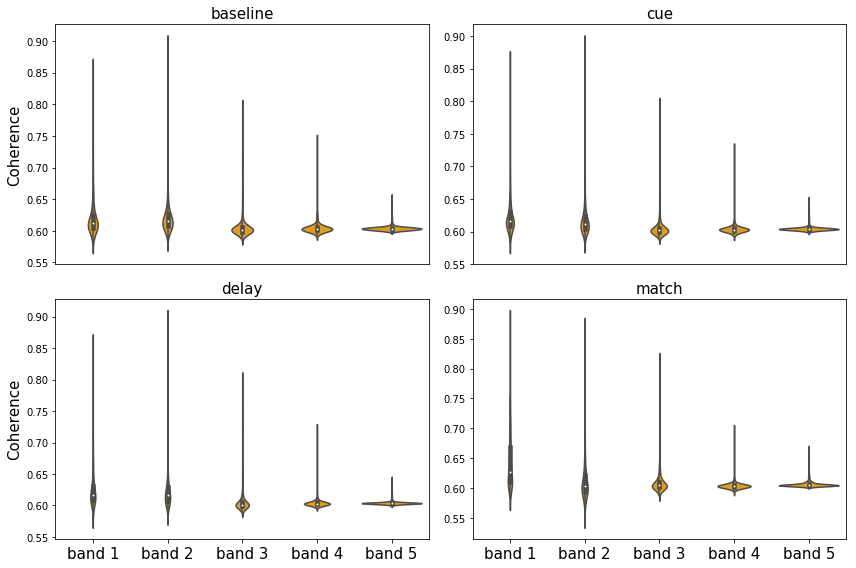

In [10]:
plt.figure(figsize=(12,8))
for j in tqdm( range( len(stages) ) ):
    plt.subplot(2,2,j+1)
    sns.violinplot(data=avg_coh[:,:,j], color='orange')
    plt.title(stages[j], fontsize=15)
    if j%2==0: plt.ylabel('Coherence', fontsize=15)
    if j==2 or j==3: plt.xticks(range(len(band_names)),band_names, fontsize=15)
    else: plt.xticks([])
plt.tight_layout()

### Analysis for default threshold parameter

In the cells bellow we perform the burstness analysis for the default thresholding parameter.

In [11]:
# Default threshold
q_thr = 0.8

In [12]:
# Instantiating a temporal network object without thresholding the data
net =  temporal_network(data_raw_path='../GrayLab/', 
           tensor_raw_path='data/', monkey=dirs['monkey'][nmonkey], 
           session=1, date=dirs['date'][nmonkey][idx], trial_type=[1],
           behavioral_response=[1], wt=(30,30), drop_trials_after=True,
           relative=True, q=q_thr, verbose=True)

Computing coherence thresholds


100%|██████████| 5/5 [00:38<00:00,  7.80s/it]


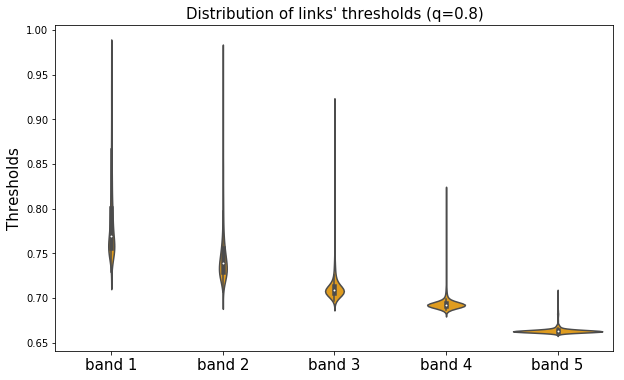

In [13]:
plt.figure(figsize=(10,6))
sns.violinplot(data=net.coh_thr, color='orange')
plt.title('Distribution of links\' thresholds (q=0.8)', fontsize=15);
plt.xticks(range(len(band_names)), band_names, fontsize=15);
plt.ylabel('Thresholds', fontsize=15);

To use the Python package igraph to compute network theory quantities it is necessary to instantiate a __Graph__ object, to do so we have to provide an adjacency matrix to the __Graph__ method. Note that the super tensor is the edge representation of the network, but we can convert it to an adjacency matrix by calling the methdo __convert_to_adjacency__ in the class __temporal_network__. This method will create the variable __A__ inside the object.

In [14]:
net.convert_to_adjacency()

#### X, Y coordinates of each node

In [15]:
xy   = scipy.io.loadmat('../Brain Areas/lucy_brainsketch_xy.mat')['xy'] # Channels coordinates
d_eu = np.zeros(net.session_info['pairs'].shape[0])
for i in range(net.session_info['pairs'].shape[0]):
    c1, c2 = net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,0]], net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,1]]
    dx = xy[c1-1,0] - xy[c2-1,0]
    dy = xy[c1-1,1] - xy[c2-1,1]
    d_eu[i] = np.sqrt(dx**2 + dy**2)

#### Mask to track observations within a task-stage

Since tha analysis is performed for each period of the experiment o have to crate masks to acess values for a specific period (baseline, cue, delay or match)

In [16]:
net.create_stage_masks(flatten=True)

### Visualizing the super tensor

Now let's take a look on the binary super-tensor by plotting its first 10 trials.

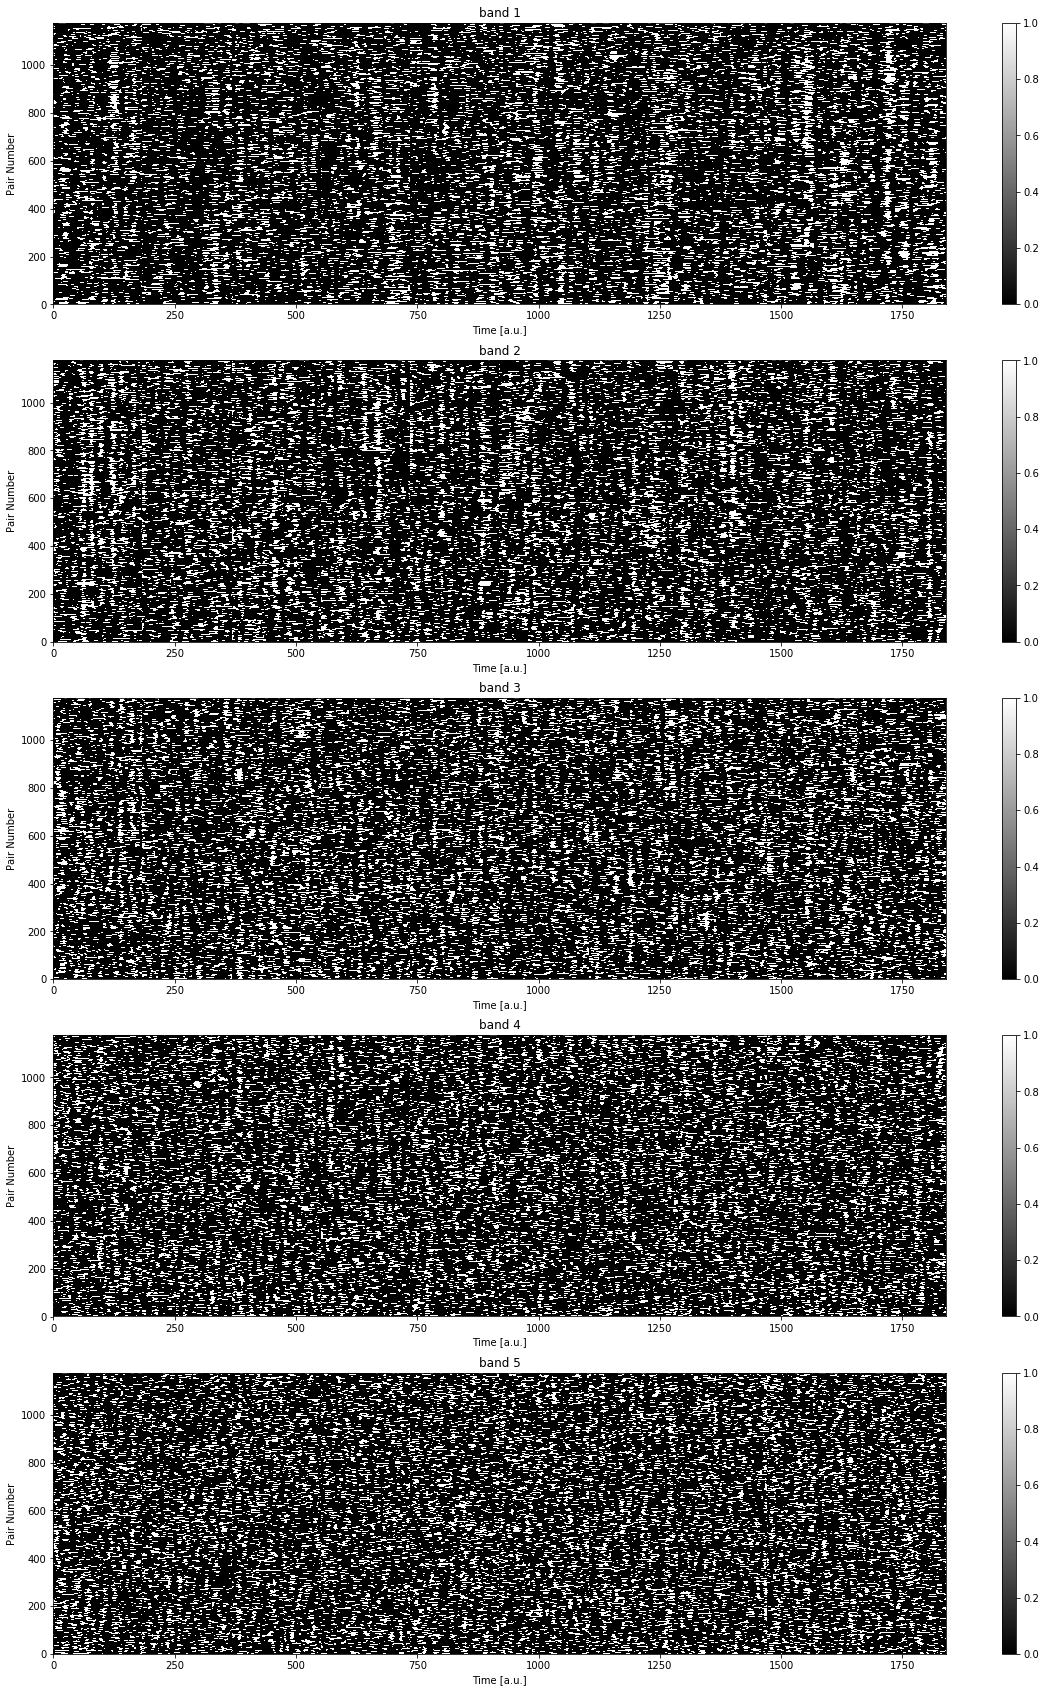

In [17]:
plt.figure(figsize=(20,30))
for i in range(len(band_names)):
    plt.subplot(len(band_names), 1, i+1)
    plt.imshow(net.super_tensor[:,i,:10,:].stack(observations=('trials','time')), 
               aspect = 'auto', cmap = 'gray', origin = 'lower', 
               extent = [0, 10*len(net.tarray), 1, net.session_info['nP']], vmin = 0, vmax = 1)
    plt.colorbar()
    plt.ylabel('Pair Number')
    plt.xlabel('Time [a.u.]')
    plt.title(band_names[i])

We can also check the super-tensor averaged over trials, which gives an idea of the probability of a certain link being active at a certain moment of the trial.

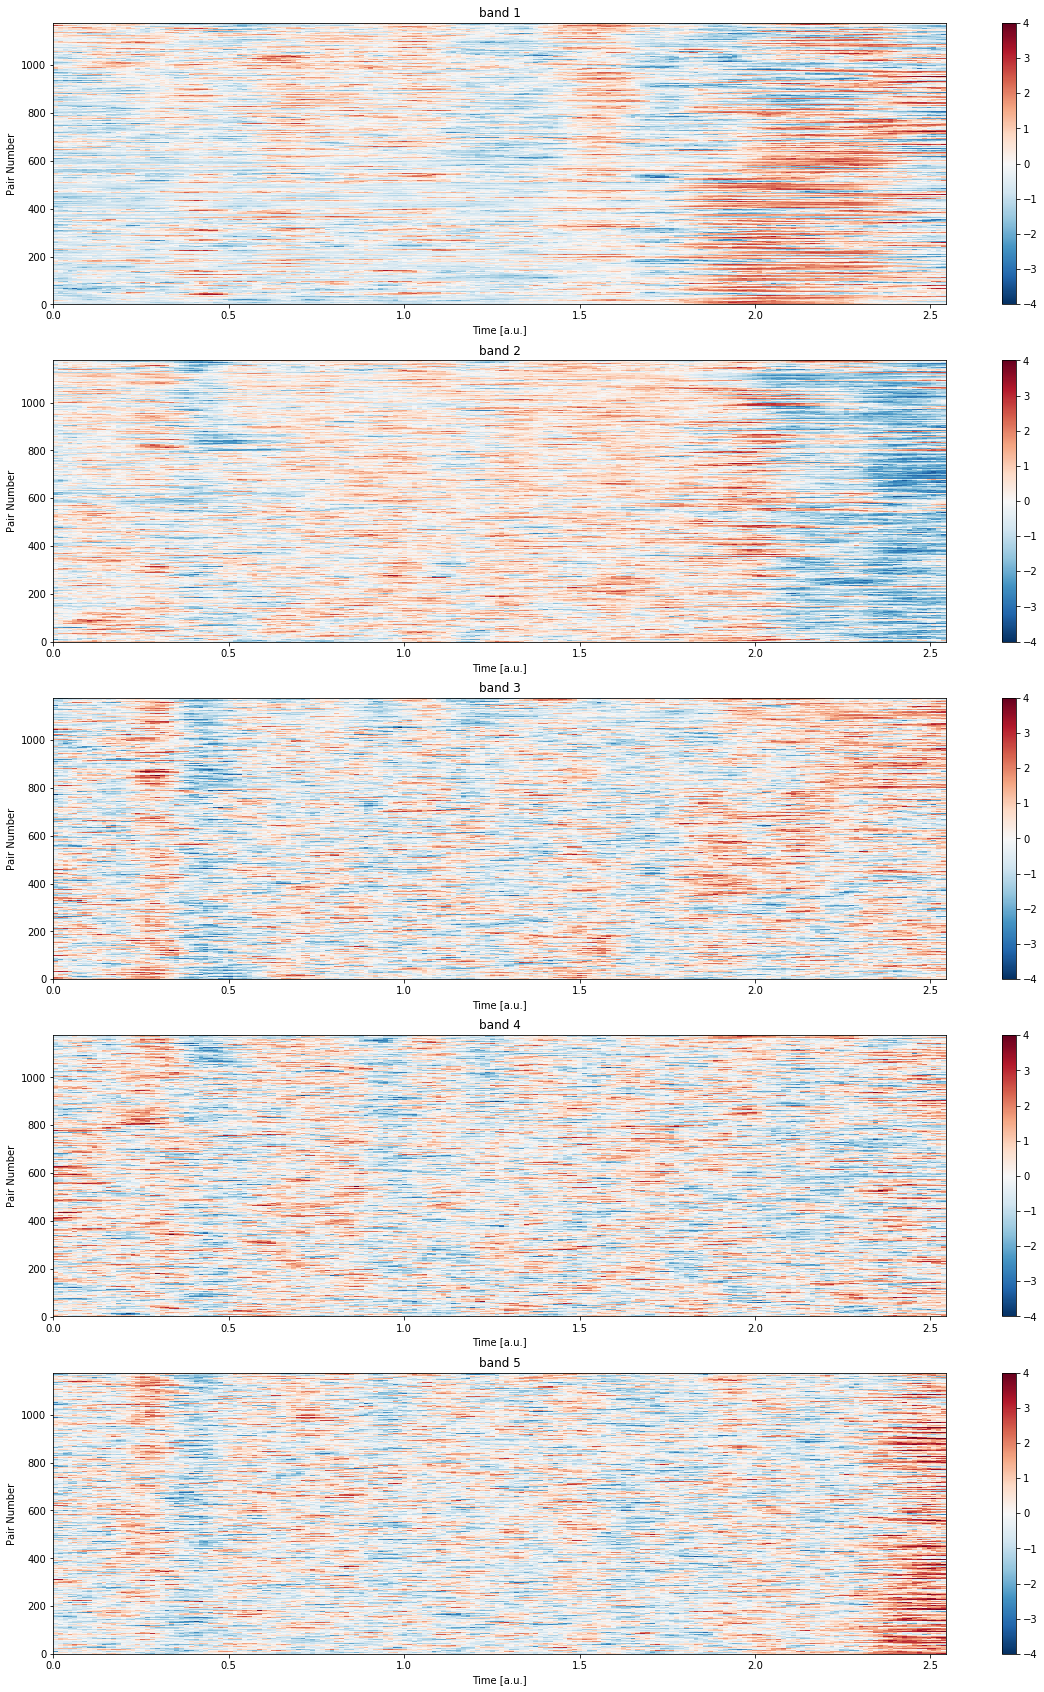

In [18]:
plt.figure(figsize=(20,30))
aux = scipy.stats.zscore(net.super_tensor.mean(dim='trials'), axis=-1)
for i in range(len(band_names)):
    plt.subplot(len(band_names), 1, i+1)
    plt.imshow(aux[:,i,:], 
               aspect = 'auto', cmap = 'RdBu_r', origin = 'lower',
               extent = [0, net.tarray[-1], 1, net.session_info['nP']], 
               vmin=-4, vmax=4)
    plt.colorbar()
    plt.ylabel('Pair Number')
    plt.xlabel('Time [a.u.]')
    plt.title(band_names[i])

#### Trial-by-trial variability and ERP

Here we show the link-averaged time-series of activations for each trials, its median and 5% and 95% quartiles.

Text(0.5, 0, 'Time [s]')

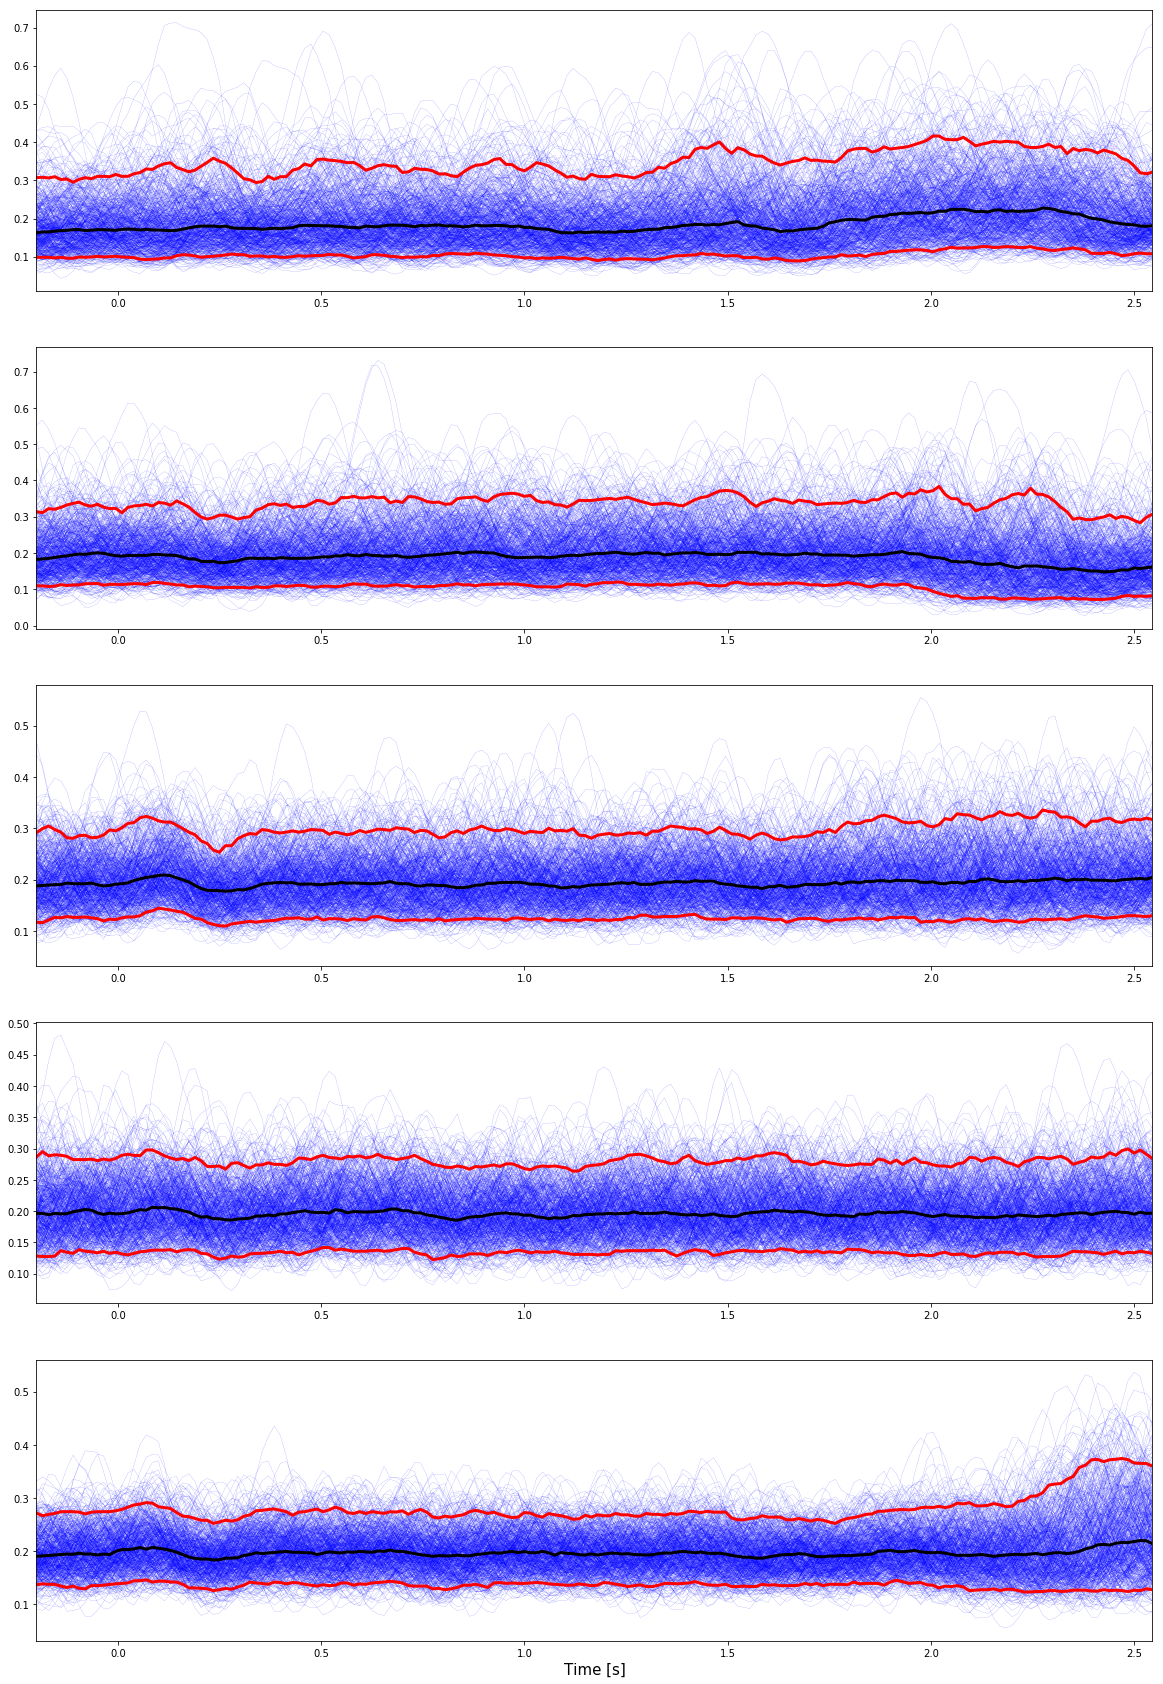

In [19]:
plt.figure(figsize=(20,30))
# Average activation sequences over links
mu_filtered_super_tensor = net.super_tensor.mean(dim='links')
for i in range(len(band_names)):
    plt.subplot(len(band_names), 1, i+1)
    for t in range(net.super_tensor.shape[2]):
        plt.plot(net.tarray, 
        mu_filtered_super_tensor.isel(trials=t, bands=i).values, 
        color='b', lw=.1)
    plt.plot(net.tarray, 
             mu_filtered_super_tensor.isel(bands=i).median(dim='trials'),
            color='k', lw=3)
    plt.plot(net.tarray, 
         mu_filtered_super_tensor.isel(bands=i).quantile(q=5/100,dim='trials'),
        color='r', lw=3)
    plt.plot(net.tarray, 
     mu_filtered_super_tensor.isel(bands=i).quantile(q=95/100,dim='trials'),
    color='r', lw=3)
    plt.xlim([net.tarray[0],net.tarray[-1]])
plt.xlabel('Time [s]', fontsize=15)

We can also project each trial time series in the 2D space using T-SNE to better visualize how the trials are distributed. For this let's use 50 trials.

100%|██████████| 5/5 [02:30<00:00, 30.09s/it]


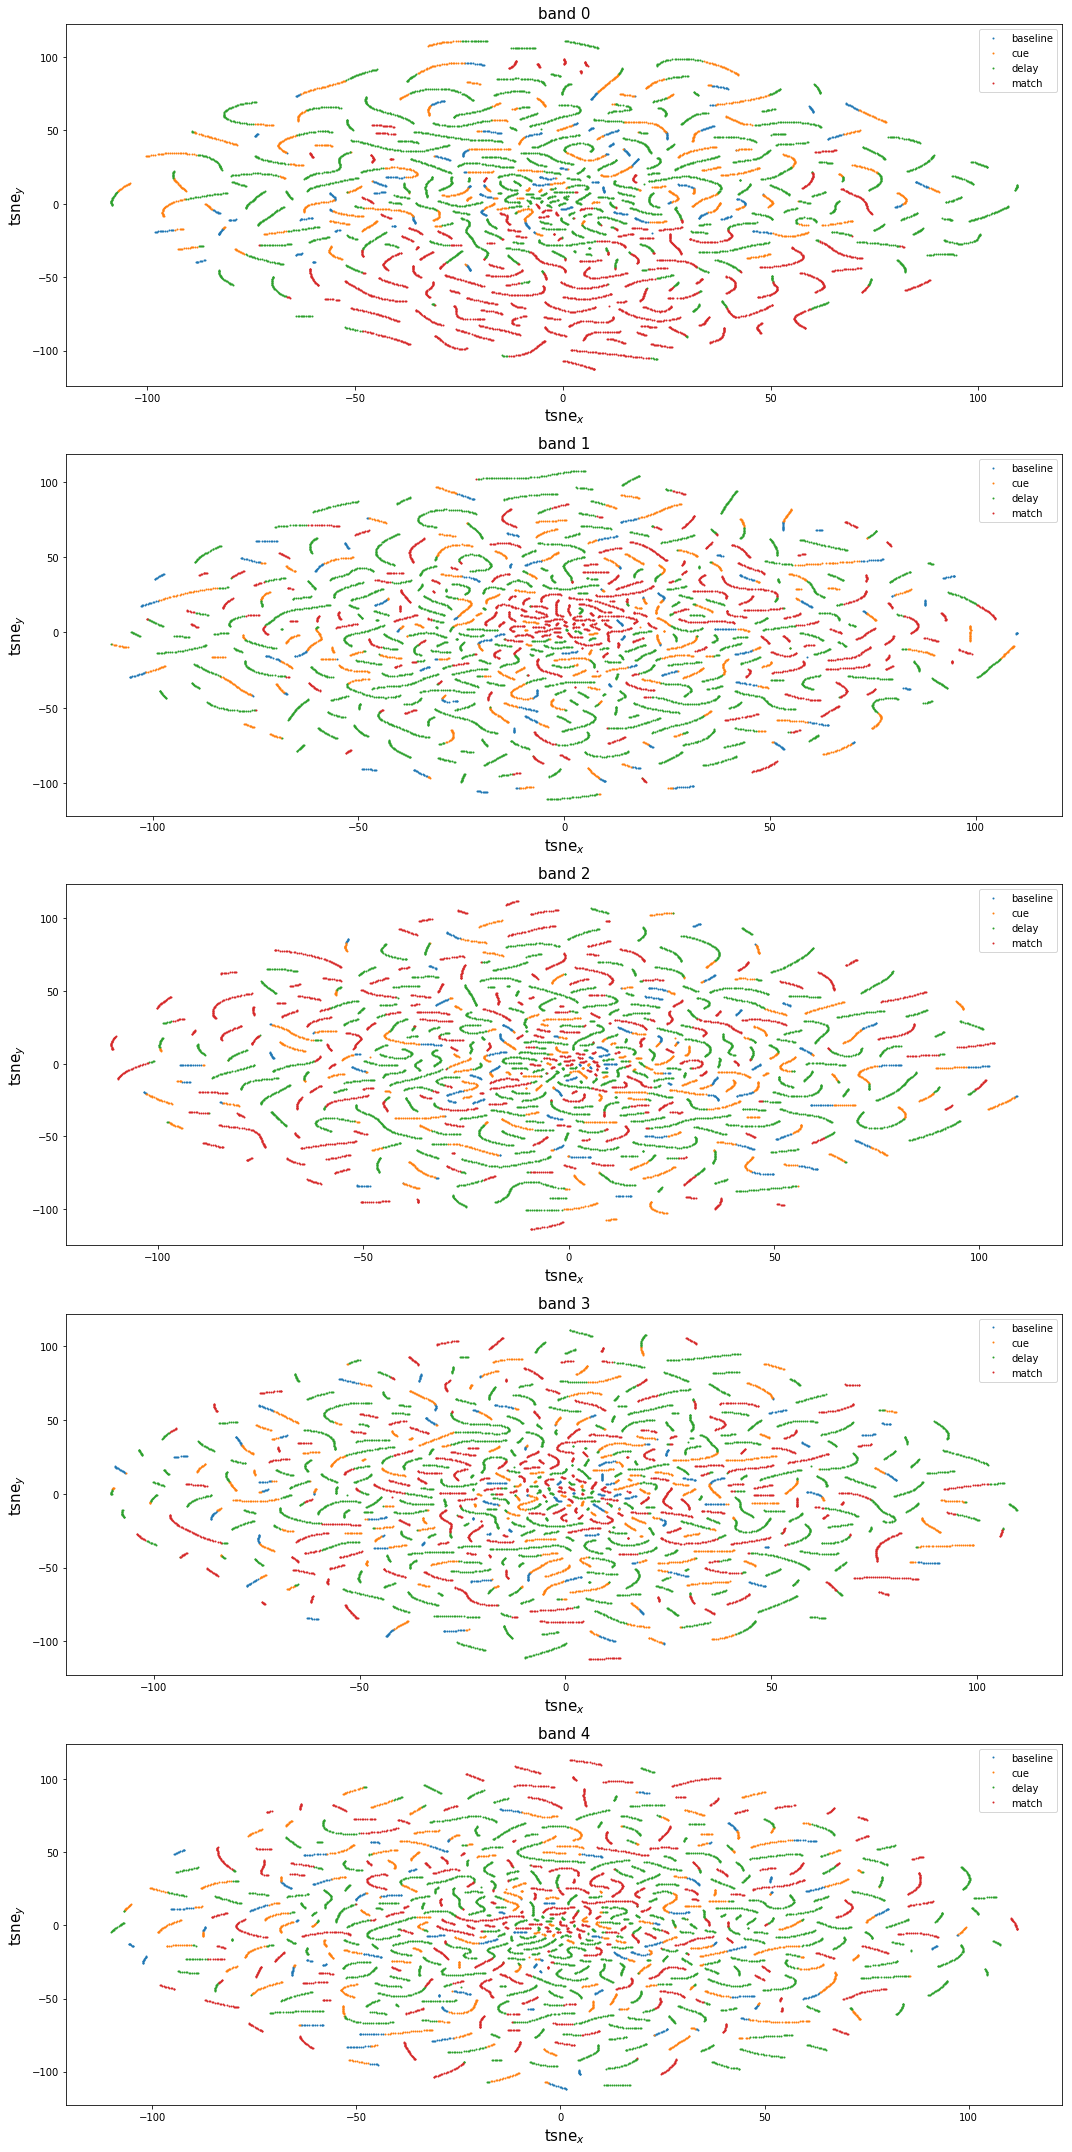

In [20]:
plt.figure(figsize=(15,30))
for j in tqdm( range(len(net.bands)) ):
    aux = net.super_tensor.isel(bands=j, trials=slice(0,50))
    aux = aux.stack(observations=("trials","time"))
    Y = TSNE(n_components=2, 
             metric='hamming', 
             perplexity=30.0,
             square_distances=True,
             n_jobs=40).fit_transform(aux.T)
    plt.subplot(len(net.bands), 1, j+1)
    for i in range(len(stages)):
        plt.plot(Y[net.s_mask[stages[i]][:50*len(net.tarray)],0], 
                 Y[net.s_mask[stages[i]][:50*len(net.tarray)],1], 
                 '.', ms=2, label = stages[i])
        plt.legend()
    plt.title(f'band {j}',    fontsize=15)
    plt.ylabel(r'tsne$_{y}$', fontsize=15)
    plt.xlabel(r'tsne$_{x}$', fontsize=15)
plt.tight_layout()

### CV distribution per band and task stage (default threshold)

Next we compute the three quantities of interest: the mean burst duration ($\mu$), the normalized total active time ($\mu_\rm{tot}$), and (CV). Bellow we briefly describe how each of those measurements in an example scenario. 

Consider the activation series for the edge $p$ composed by nodes $i$ and $j$ ($p=\{i,j\}$) and trial $T$: $A_{p}^{T}=\{00011100001100111111\}$.

1. the mean burst duration ($\mu$): In the example above $A_{p}^{T}$ has three activation bursts of sizes $3$, $2$, and $6$, therefore $\mu$ = mean(3,2,6) ~ 3.7 a.u. and standard deviantion $\sigma_{\mu}$ = std(3,2,6) ~ 1.7 a.u.;

2. the normalized total active time ($\mu_\rm{tot}$): The total active time is given by: $len(A_{p}^{T})^{-1}\sum A_{p}^{T}$. If a specif stage $s$ of the experiment is analysed for all trials we consider the concatenated activations series: $A_{p}(s)$, if $n(s)^T$ is the number of observations in stage $s$ at trial $T$ then: $\mu_\rm{tot} = 
(\sum_{T}n(s)^T)^{-1}\sum A_{p}(s)$;

3. Burstness CV: The burstness CV is computed from step one as: CV = $\sigma_{\mu}/\mu$.

In [ ]:
# Burstiness analysis statistics
bs_stats = np.zeros((net.super_tensor.sizes['links'],net.super_tensor.sizes['bands'],len(stages), 3))
for j in tqdm( range(len(stages)) ):
    bs_stats[:,:,j,:]=np.apply_along_axis(bst.compute_burstness_stats, -1, 
                      net.get_data_from(stage=stages[j], pad=True), 
                      samples = net.get_number_of_samples(stage=stages[j]), 
                      dt=delta/net.super_tensor.attrs['fsample'])

In [ ]:
titles = ['Mean burst duration', 'Norm. total active time', 'CV']
bins   = [np.linspace(0.07,0.14,50), np.linspace(0.12,0.30,50), np.linspace(0.55,0.85,50) ]
plt.figure(figsize=(20,20))
count = 1
for i in range(len(net.bands)):
    for k in range(3):
        plt.subplot(5,3,count)
        for j in range(len(stages)):
            sns.kdeplot(data=bs_stats[:,i,j,k], shade=True)
            if i==0: plt.title(titles[k], fontsize=15)
            #if i<4: plt.xticks([])
            if count in [1,4,7,10,13]: plt.ylabel(f'Band {i}', fontsize=15)
        plt.legend(['baseline','cue','delay','match'])
        count+=1
plt.savefig('img/stat_dists_q03.pdf', dpi=300)

In [ ]:
titles = ['Mean burst duration', 'Norm. total active time', 'CV']
plt.figure(figsize=(20,5))
for k in range(3):
    plt.subplot(1,3,k+1)
    for j in range(len(net.bands)):
        p=bs_stats[:,j,0,k]
        c=bs_stats[:,j,1,k]
        d=bs_stats[:,j,2,k]
        m=bs_stats[:,j,3,k]
        plt.errorbar(range(4), [p.mean(), c.mean(), d.mean(), m.mean()], 
                     [p.std()/np.sqrt(1176), c.std()/np.sqrt(1176), d.std()/np.sqrt(1176), m.std()/np.sqrt(1176)])
        plt.xticks(range(4), ['baseline', 'cue', 'delay', 'match'], fontsize=15)
        plt.title(titles[k], fontsize=15)
    plt.legend(band_names)

In [ ]:
mu     = np.zeros([49, 49, len(net.bands), len(stages)])  
mu_tot = np.zeros([49, 49, len(net.bands), len(stages)]) 
CV     = np.zeros([49, 49, len(net.bands), len(stages)]) 
for j in range( net.session_info['pairs'].shape[0]):
    mu[net.session_info['pairs'][j,0], net.session_info['pairs'][j,1], :, :]     = bs_stats[j,:,:,0]
    mu_tot[net.session_info['pairs'][j,0], net.session_info['pairs'][j,1], :, :] = bs_stats[j,:,:,1]
    CV[net.session_info['pairs'][j,0], net.session_info['pairs'][j,1], :, :]     = bs_stats[j,:,:,2]

In [ ]:
plt.figure(figsize=(15,15))
count = 1
for k in tqdm( range(len(net.bands)) ):
    for i in range(len(stages)):
        plt.subplot(len(net.bands),len(stages),count)
        aux = (mu[:,:,k,i]+mu[:,:,k,i].T) 
        plt.imshow(aux, aspect='auto', 
                   cmap='jet', origin='lower', 
                   vmin=0, vmax=np.median(mu[:,:,k,:]+mu[:,:,k,:].transpose(1,0,2)*4) )
        plt.colorbar()
        if stages[i] == 'baseline': plt.yticks(range(49), ses.data.roi.values)
        else: plt.yticks([])
        if k == 4: plt.xticks(range(49), ses.data.roi.values, rotation=90)
        else: plt.xticks([])
        if k == 0: plt.title(stages[i], fontsize=15)
        if stages[i] == 'baseline': plt.ylabel(band_names[k], fontsize=15)
        #plt.colorbar()
        count+=1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(15,15))
count = 1
for k in tqdm( range(len(net.bands)) ):
    for i in range(len(stages)):
        plt.subplot(len(net.bands),len(stages),count)
        aux = (mu_tot[:,:,k,i]+mu_tot[:,:,k,i].T) 
        plt.imshow(aux, aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=0.3)
        plt.colorbar()
        if stages[i] == 'baseline': plt.yticks(range(49), ses.data.roi.values)
        else: plt.yticks([])
        if k == 4: plt.xticks(range(49), ses.data.roi.values, rotation=90)
        else: plt.xticks([])
        if k == 0: plt.title(stages[i], fontsize=15)
        if stages[i] == 'baseline': plt.ylabel(band_names[k], fontsize=15)
        #plt.colorbar()
        count+=1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(15,15))
count = 1
for k in tqdm( range(len(net.bands)) ):
    for i in range(len(stages)):
        plt.subplot(len(net.bands),len(stages),count)
        aux = (CV[:,:,k,i]+CV[:,:,k,i].T) 
        plt.imshow(aux**6, aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=0.3)
        plt.colorbar()
        if stages[i] == 'baseline': plt.yticks(range(49), ses.data.roi.values)
        else: plt.yticks([])
        if k == 4: plt.xticks(range(49), ses.data.roi.values, rotation=90)
        else: plt.xticks([])
        if k == 0: plt.title(stages[i], fontsize=15)
        if stages[i] == 'baseline': plt.ylabel(band_names[k], fontsize=15)
        #plt.colorbar()
        count+=1
plt.tight_layout()

###  Effect of threshold variation

In [25]:
q_list = np.arange(0.2, 1.0, 0.1)
cv     = np.zeros([net.super_tensor.shape[0], len(net.bands), 3, len(stages), len(q_list)])

for i in tqdm( range(len(q_list)) ):
    # Instantiating a temporal network object without thresholding the data
    net =  temporal_network(data_raw_path='../GrayLab/', 
           tensor_raw_path='data/', monkey=dirs['monkey'][nmonkey], 
           session=1, date=dirs['date'][nmonkey][idx], trial_type=[1],
           behavioral_response=[1], wt=(30,30), drop_trials_after=False,
           relative=True, q=q_list[i], verbose=False)
 
    for j,s in zip(range(len(stages)),stages):
        cv[...,j,i]  = np.apply_along_axis(bst.compute_burstness_stats, -1, 
                       net.get_data_from(stage=s,pad=True),
                       samples = net.get_number_of_samples(stage=s), 
                       dt      = delta/net.super_tensor.attrs['fsample'])

100%|██████████| 8/8 [08:36<00:00, 64.54s/it]


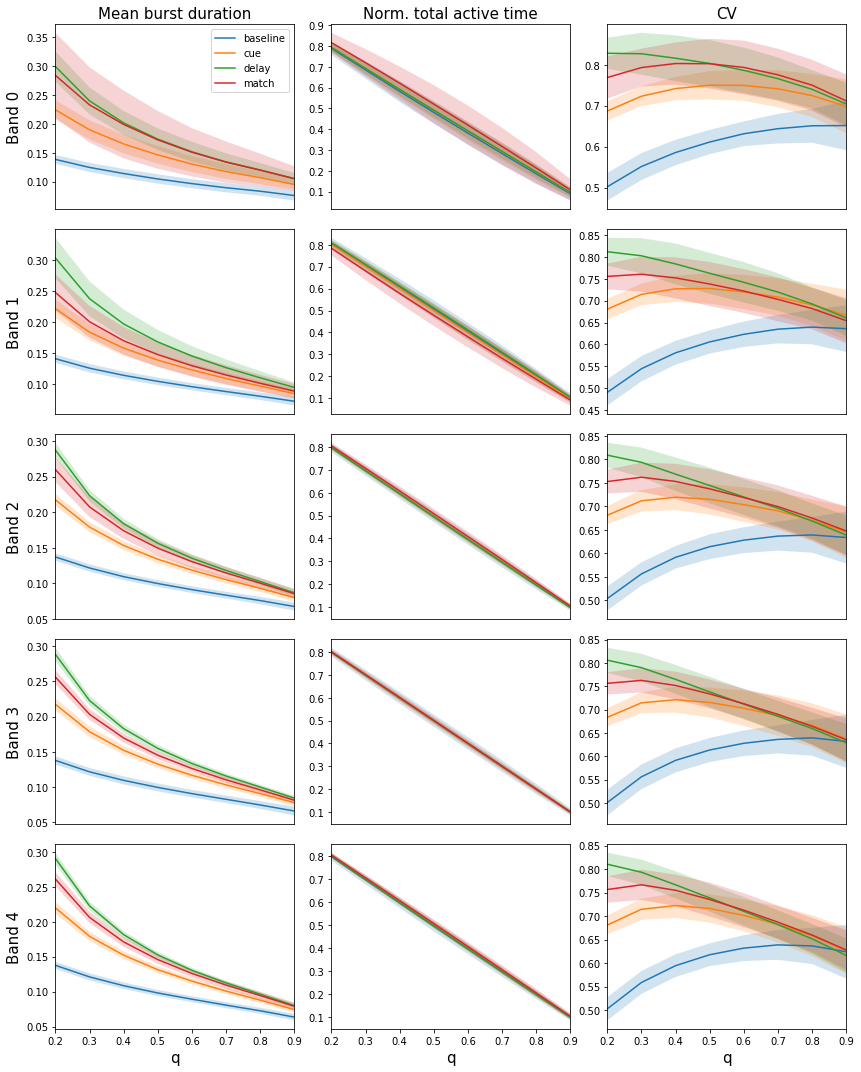

In [26]:
titles = ['Mean burst duration', 'Norm. total active time', 'CV']
plt.figure(figsize=(12,15))
count = 1
for i in range(len(net.bands)):
    for k in range(3):
        plt.subplot(5,3,count)
        for s in range(len(stages)):
            v_median = np.median(  cv[:,i,k,s,:],axis=0)
            v_q05    = np.quantile(cv[:,i,k,s,:], 5/100, axis=0)
            v_q95    = np.quantile(cv[:,i,k,s,:], 95/100, axis=0)
            diq      = (v_q95-v_q05)/2
            plt.plot(q_list, v_median, label=stages[s])
            plt.fill_between(q_list, v_median-diq, v_median+diq, alpha=0.2)
        count +=1
        plt.xlim([0.2,0.9])
        if k == 0: plt.ylabel(f'Band {i}', fontsize=15)
        if i == 0: plt.title(titles[k], fontsize=15)
        if i < 4:  plt.xticks([])
        if i == 0 and k==0: plt.legend()
        if i == 4: plt.xlabel('q', fontsize=15)
plt.tight_layout()
plt.savefig('img/q_dependece.pdf', dpi=300)

In [23]:
def plot_dists(q):
    # Instantiating a temporal network object without thresholding the data
    net =  temporal_network(data_raw_path = '../GrayLab/', tensor_raw_path = 'data/', 
                            monkey='lucy', session=1, date='150128', wt=(30,30),
                            relative=True, q=q, verbose=False)
    # Compute stats
    # Burstiness analysis statistics
    bs_stats = np.zeros((net.super_tensor.sizes['links'],net.super_tensor.sizes['bands'],len(stages), 3))
    for j in tqdm( range(len(stages)) ):
        bs_stats[:,:,j,:]=np.apply_along_axis(bst.compute_burstness_stats, -1, 
                          net.get_data_from(stage=stages[j], pad=True), 
                          samples = net.get_number_of_samples(stage=stages[j]), 
                          dt=delta/net.super_tensor.attrs['fsample'])
        
    titles = ['Mean burst duration', 'Norm. total active time', 'CV']
    plt.figure(figsize=(20,20))
    count = 1
    for i in range(len(net.bands)):
        for k in range(3):
            plt.subplot(5,3,count)
            for j in range(len(stages)):
                sns.kdeplot(data=bs_stats[:,i,j,k], shade=True)
                if i==0: plt.title(titles[k], fontsize=15)
                #if i<4: plt.xticks([])
                if count in [1,4,7,10,13]: plt.ylabel(f'Band {i}', fontsize=15)
            plt.legend(['baseline','cue','delay','match'])
            count+=1

#### Stats distribution (q=0.3)

100%|██████████| 4/4 [00:21<00:00,  5.45s/it]


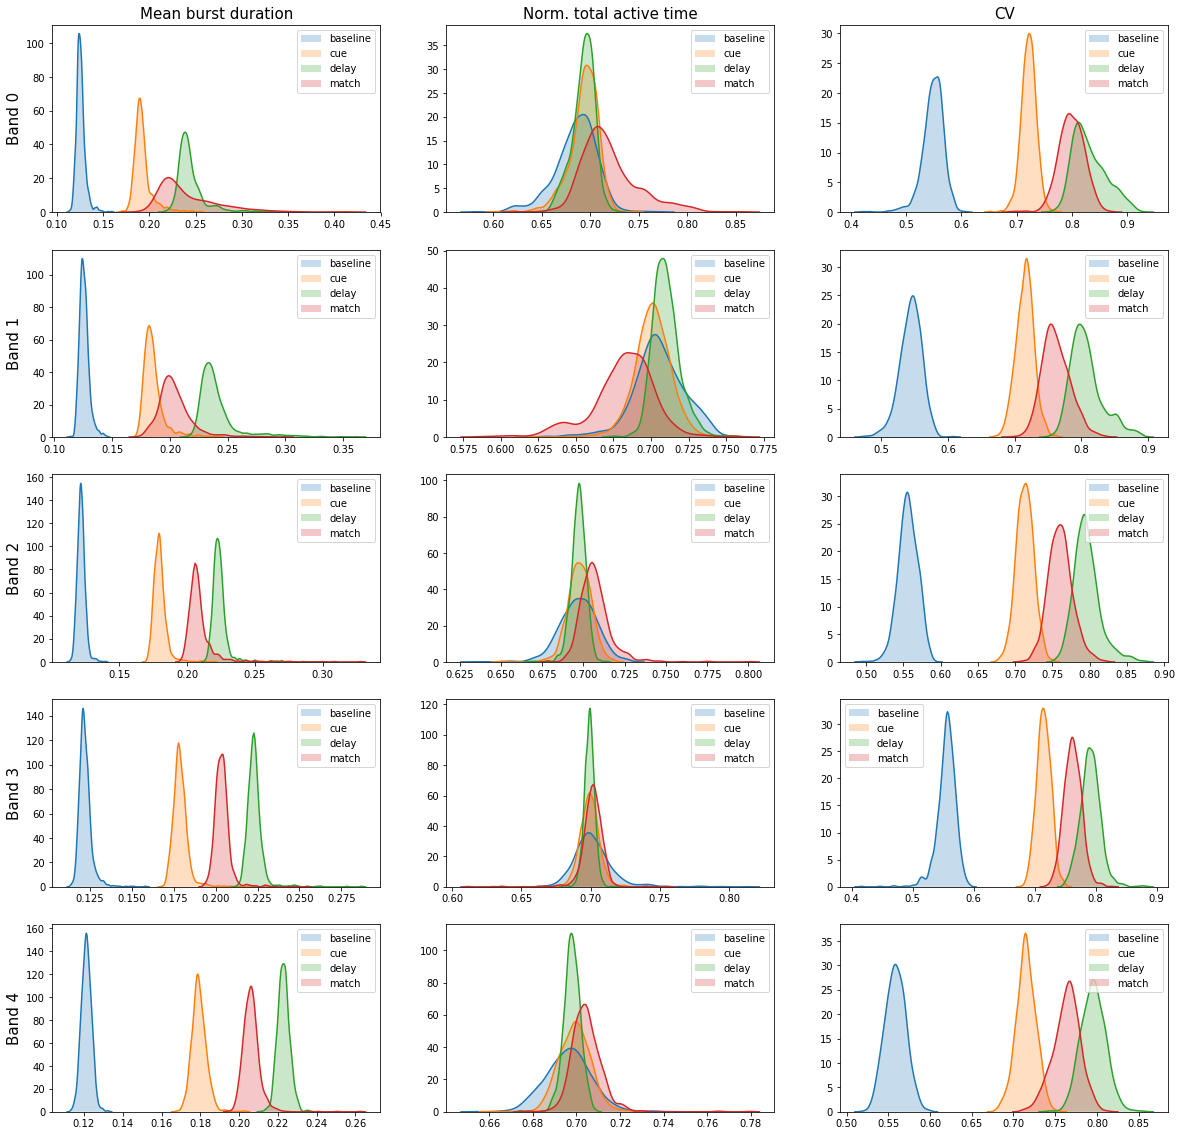

In [24]:
plot_dists(0.3)

100%|██████████| 4/4 [00:21<00:00,  5.29s/it]


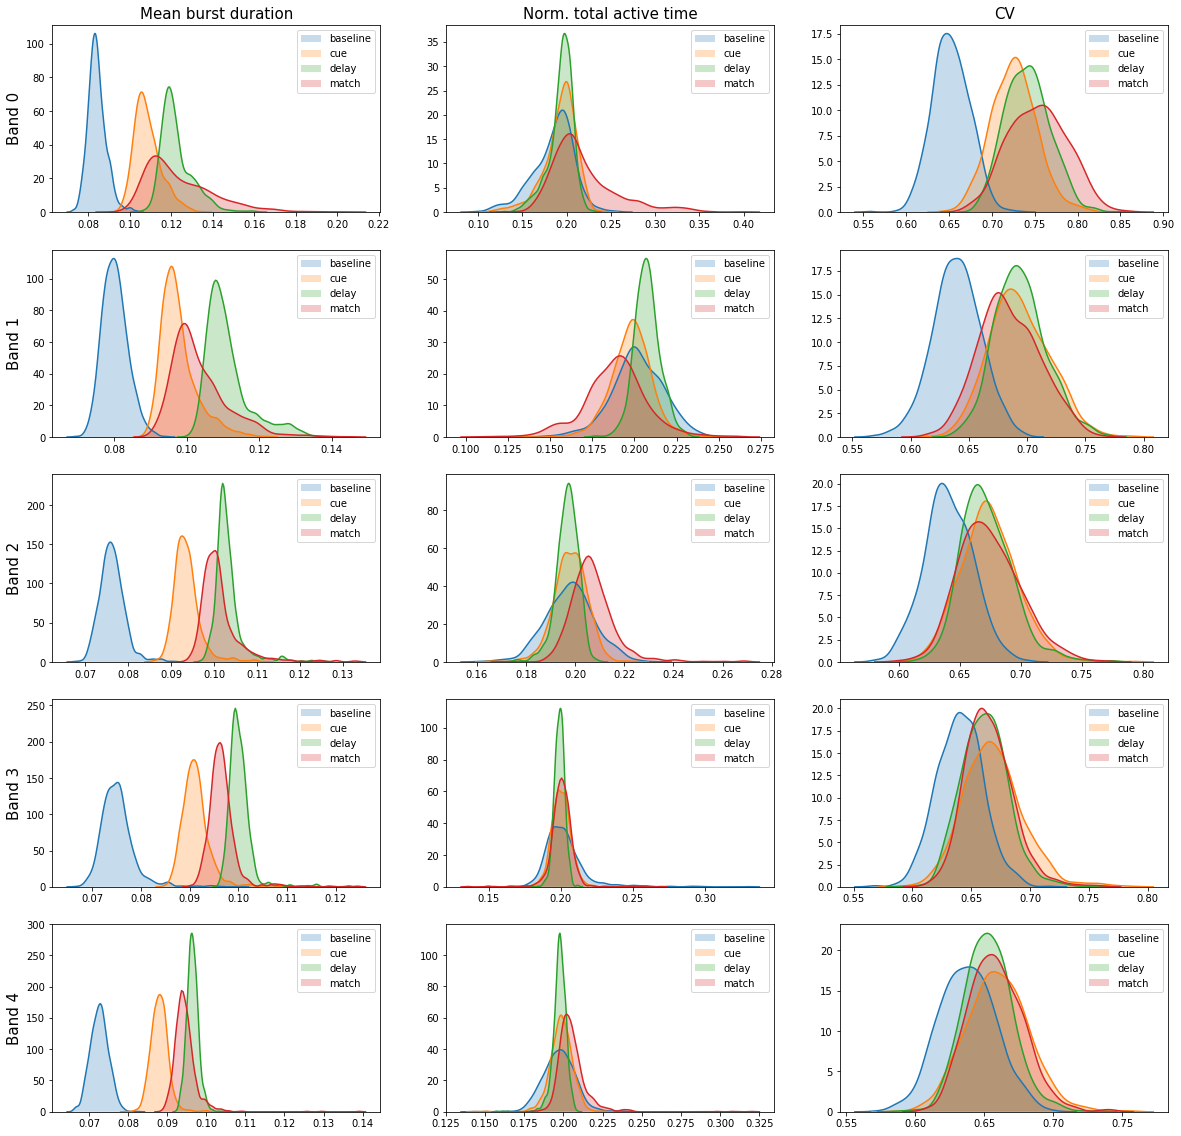

In [25]:
plot_dists(0.8)

#### Burstness vs active time (q=0.8)

In [ ]:
plt.figure(figsize=(15,20))
count = 1
x_min, x_max = bs_stats[...,0].min(), bs_stats[...,0].max()
y_min, y_max = bs_stats[...,2].min(), bs_stats[...,2].max()
bins         = [np.linspace(x_min,x_max,20),np.linspace(y_min, y_max,20)]
for j in tqdm( range(len(net.bands)) ):
    Hb, xb, yb = np.histogram2d(bs_stats[:,j,0,0], bs_stats[:,j,0,2], 
                                bins=bins, density = True  )
    for i in range(1,len(stages)):     
        # Plotting top links
        plt.subplot(len(net.bands), len(stages)-1, count)
        H, xb, yb = np.histogram2d(bs_stats[:,j,i,0], bs_stats[:,j,i,2], 
                               bins=bins, density = True )
        plt.imshow(H-Hb, aspect='auto', cmap='RdBu_r', origin='lower', 
                   extent=[1000*xb[0],1000*xb[-1],yb[0],yb[-1]], 
                   interpolation='gaussian', vmin=-1000, vmax=1000)
        plt.colorbar()
        if j < 4 : plt.xticks([])
        if i > 1 : plt.yticks([])
        if j == 4: plt.xlabel('Mean burst dur. [ms]', fontsize=15)
        if j == 0: plt.title(f'{stages[i]}-baseline', fontsize=15)
        if i == 1: plt.ylabel('CV', fontsize=15)
        count += 1
plt.tight_layout()

#### Burstiness vs electrode distance (default q)

In [ ]:
plt.figure(figsize=(15,20))
count = 1
x_min, x_max = d_eu.min(), d_eu.max()
y_min, y_max = bs_stats[...,2].min(), bs_stats[...,2].max()
bins         = [np.linspace(x_min,x_max,20),np.linspace(y_min, y_max,20)]
for j in tqdm( range(len(net.bands)) ):
    Hb, xb, yb = np.histogram2d(d_eu, bs_stats[:,j,0,2], 
                                bins=bins, density = True  )
    for i in range(1,len(stages)):     
        # Plotting top links
        plt.subplot(len(net.bands), len(stages)-1, count)
        H, xb, yb = np.histogram2d(d_eu, bs_stats[:,j,i,2], 
                               bins=bins, density = True )
        plt.imshow(H-Hb, aspect='auto', cmap='RdBu_r', origin='lower', 
                   extent=[xb[0],xb[-1],yb[0],yb[-1]], 
                   interpolation='gaussian', vmin=-0.02, vmax=0.02)
        plt.colorbar()
        if j < 4 : plt.xticks([])
        if i > 1 : plt.yticks([])
        if j == 4: plt.xlabel('Euclidian distance', fontsize=15)
        if j == 0: plt.title(f'{stages[i]}-baseline', fontsize=15)
        if i == 1: plt.ylabel('CV', fontsize=15)
        count += 1
plt.tight_layout()

### Meta-connectivity analysis

In [ ]:
CCij = np.zeros([len(net.bands), net.session_info['nP'],net.session_info['nP'],len(stages)])

for s in tqdm( range(len(stages)) ):
    aux = net.get_data_from(stage=stages[s],pad=False)
    for b in range(len(net.bands)):
        CCij[b,:,:,s] = np.corrcoef(aux[:,b,:].values, rowvar=True) 
CCij[:,range(1176),range(1176),:] = 0

In [ ]:
plt.figure(figsize=(20,20))
count = 1
for b in range(len(net.bands)):
    for i in range(len(stages)):
        plt.subplot(len(net.bands),len(stages),count)
        plt.imshow(CCij[b,...,i], aspect='auto', cmap='RdBu_r', origin='lower', 
                   vmin=-CCij[b,...].mean()*3, vmax=CCij[b,...].mean()*3)
        if b == 0: plt.title(stages[i], fontsize=15)
        if i == 0: plt.ylabel(band_names[b], fontsize=15)
        plt.colorbar(extend='both')
        count+=1
plt.tight_layout()

### Cross-frequency coupling

In [ ]:
# All possible band pairs
i,j = np.triu_indices(5,k=1)
bp  = np.array([i,j]).T

In [ ]:
CCmulti = np.zeros([len(bp), net.session_info['nP'],net.session_info['nP'],len(stages)])

for s in tqdm( range(len(stages)) ):
    aux = net.get_data_from(stage=stages[s], pad=False)
    for b, band_1, band_2 in zip(range( len(bp) ), i, j):
        CCmulti[b,...,s]=\
        np.corrcoef(aux[:,band_1,:], aux[:,band_2,:], rowvar=True)[net.session_info['nP']:,:net.session_info['nP']]

In [ ]:
plt.figure(figsize=(20,8))
count = 1
for b in range( len(bp) ):
    plt.subplot(2,5,count)
    plt.imshow(CCmulti[b,...,2], aspect='auto', cmap='RdBu_r', origin='lower', vmin=-0.04,vmax=0.04)
    plt.colorbar(extend='both')
    plt.title(f'band {bp[b,0]}-band {bp[b,1]}', fontsize=15)
    count+=1
plt.tight_layout()

#### Average multiplex CC

### Comparison with fixation

In [ ]:
# Instantiating a temporal network object without thresholding the data
net_fix =  temporal_network(data_raw_path='../GrayLab/', 
           tensor_raw_path='data/', monkey=dirs['monkey'][nmonkey], 
           session=1, date=dirs['date'][nmonkey][idx], trial_type=[2],
           behavioral_response=None, wt=(30,30), drop_trials_after=False,
           relative=True, q=q_thr, verbose=True)

In [ ]:
plt.figure(figsize=(20,30))
for i in range(len(band_names)):
    plt.subplot(len(band_names), 1, i+1)
    plt.imshow(net_fix.super_tensor[:,i,:10,:].stack(observations=('trials','time')), 
               aspect = 'auto', cmap = 'gray', origin = 'lower', 
               extent = [0, 10*len(net.tarray), 1, net.session_info['nP']], vmin = 0, vmax = 1)
    plt.colorbar()
    plt.ylabel('Pair Number')
    plt.xlabel('Time [a.u.]')
    plt.title(band_names[i])

In [ ]:
plt.figure(figsize=(20,30))
aux = scipy.stats.zscore(net_fix.super_tensor.mean(dim='trials'), axis=-1)
for i in range(len(band_names)):
    plt.subplot(len(band_names), 1, i+1)
    plt.imshow(aux[:,i,:], 
               aspect = 'auto', cmap = 'RdBu_r', origin = 'lower',
               extent = [0, net.tarray[-1], 1, net.session_info['nP']], 
               vmin=-4, vmax=4)
    plt.colorbar()
    plt.ylabel('Pair Number')
    plt.xlabel('Time [a.u.]')
    plt.title(band_names[i])

In [ ]:
# Burstiness analysis statistics
bs_stats_fix = np.zeros((net_fix.super_tensor.sizes['links'],net_fix.super_tensor.sizes['bands'],len(stages), 3))
for j in tqdm( range(len(stages)) ):
    bs_stats_fix[:,:,j,:]=np.apply_along_axis(bst.compute_burstness_stats, -1, 
                      net_fix.get_data_from(stage=stages[j], pad=True), 
                      samples = net_fix.get_number_of_samples(stage=stages[j]), 
                      dt=delta/net_fix.super_tensor.attrs['fsample'])

In [ ]:
titles = ['Mean burst duration', 'Norm. total active time', 'CV']
colors = ['b', 'r', 'g', 'm']
plt.figure(figsize=(20,20))
count = 1
for i in range(len(net_fix.bands)):
    for k in range(3):
        plt.subplot(5,3,count)
        for j in range(len(stages)):
            sns.kdeplot(data=bs_stats_fix[:,i,j,k], shade=False, color=colors[j])
            sns.kdeplot(data=bs_stats[:,i,j,k], shade=False, ls='--', color=colors[j])
            if i==0: plt.title(titles[k], fontsize=15)
            #if i<4: plt.xticks([])
            if count in [1,4,7,10,13]: plt.ylabel(f'Band {i}', fontsize=15)
        plt.legend(['baseline','cue','delay','match'])
        count+=1

In [ ]:
plt.figure(figsize=(15,30))
for j in tqdm( range(len(net_fix.bands)) ):
    aux = net_fix.super_tensor.isel(bands=j, trials=slice(0,50))
    aux = aux.stack(observations=("trials","time"))
    Y = TSNE(n_components=2, 
             metric='hamming', 
             perplexity=30.0,
             square_distances=True,
             n_jobs=40).fit_transform(aux.T)
    plt.subplot(len(net_fix.bands), 1, j+1)
    for i in range(len(stages)):
        plt.plot(Y[net_fix.s_mask[stages[i]][:50*len(net.tarray)],0], 
                 Y[net_fix.s_mask[stages[i]][:50*len(net.tarray)],1], 
                 '.', ms=2, label = stages[i])
        plt.legend()
    plt.title(f'band {j}',    fontsize=15)
    plt.ylabel(r'tsne$_{y}$', fontsize=15)
    plt.xlabel(r'tsne$_{x}$', fontsize=15)
plt.tight_layout()

#### Burstness vs active time (comp. baseline)

In [ ]:
plt.figure(figsize=(15,20))
count = 1
x_min, x_max = bs_stats_fix[...,0].min(), bs_stats_fix[...,0].max()
y_min, y_max = bs_stats_fix[...,2].min(), bs_stats_fix[...,2].max()
bins         = [np.linspace(x_min,x_max,20),np.linspace(y_min, y_max,20)]
for j in tqdm( range(len(net_fix.bands)) ):
    Hb, xb, yb = np.histogram2d(bs_stats_fix[:,j,0,0], bs_stats_fix[:,j,0,2], 
                                bins=bins, density = True  )
    for i in range(1,len(stages)):     
        # Plotting top links
        plt.subplot(len(net_fix.bands), len(stages)-1, count)
        H, xb, yb = np.histogram2d(bs_stats_fix[:,j,i,0], bs_stats_fix[:,j,i,2], 
                               bins=bins, density = True )
        plt.imshow(H-Hb, aspect='auto', cmap='RdBu_r', origin='lower', 
                   extent=[1000*xb[0],1000*xb[-1],yb[0],yb[-1]], 
                   interpolation='gaussian', vmin=-300, vmax=300)
        plt.colorbar()
        if j < 4 : plt.xticks([])
        if i > 1 : plt.yticks([])
        if j == 4: plt.xlabel('Mean burst dur. [ms]', fontsize=15)
        if j == 0: plt.title(f'{stages[i]}-baseline', fontsize=15)
        if i == 1: plt.ylabel('CV', fontsize=15)
        count += 1
plt.tight_layout()

#### Burstiness vs electrode distance (comp. baseline)

In [ ]:
plt.figure(figsize=(15,20))
count = 1
x_min, x_max = d_eu.min(), d_eu.max()
y_min, y_max = bs_stats_fix[...,2].min(), bs_stats_fix[...,2].max()
bins         = [np.linspace(x_min,x_max,20),np.linspace(y_min, y_max,20)]
for j in tqdm( range(len(net_fix.bands)) ):
    Hb, xb, yb = np.histogram2d(d_eu, bs_stats_fix[:,j,0,2], 
                                bins=bins, density = True  )
    for i in range(1,len(stages)):     
        # Plotting top links
        plt.subplot(len(net_fix.bands), len(stages)-1, count)
        H, xb, yb = np.histogram2d(d_eu, bs_stats_fix[:,j,i,2], 
                               bins=bins, density = True )
        plt.imshow(H-Hb, aspect='auto', cmap='RdBu_r', origin='lower', 
                   extent=[xb[0],xb[-1],yb[0],yb[-1]], 
                   interpolation='gaussian', vmin=-0.01, vmax=0.01)
        plt.colorbar()
        if j < 4 : plt.xticks([])
        if i > 1 : plt.yticks([])
        if j == 4: plt.xlabel('Euclidian distance', fontsize=15)
        if j == 0: plt.title(f'{stages[i]}-baseline', fontsize=15)
        if i == 1: plt.ylabel('CV', fontsize=15)
        count += 1
plt.tight_layout()

#### Burstness vs active time (ODRT - baseline)

In [ ]:
plt.figure(figsize=(15,20))
count = 1
x_min, x_max = bs_stats[...,0].min(), bs_stats[...,0].max()
y_min, y_max = bs_stats[...,2].min(), bs_stats[...,2].max()
bins         = [np.linspace(x_min,x_max,20),np.linspace(y_min, y_max,20)]
for j in tqdm( range(len(net_fix.bands)) ):
    for i in range( len(stages) ):     
        # Plotting top links
        plt.subplot(len(net_fix.bands), len(stages), count)
        # ODRT 
        Hb, _, _   = np.histogram2d(bs_stats[:,j,i,0], bs_stats_fix[:,j,0,2], 
                                bins=bins, density = True  )
        # BASELINE 
        H,  xb, yb = np.histogram2d(bs_stats_fix[:,j,i,0], bs_stats_fix[:,j,i,2], 
                               bins=bins, density = True )
        plt.imshow(Hb-H, aspect='auto', cmap='RdBu_r', origin='lower', 
                   extent=[1000*xb[0],1000*xb[-1],yb[0],yb[-1]], 
                   interpolation='gaussian', vmin=-300, vmax=300)
        plt.colorbar()
        if j < 4 : plt.xticks([])
        if i > 1 : plt.yticks([])
        if j == 4: plt.xlabel('Mean burst dur. [ms]', fontsize=15)
        if j == 0: plt.title(f'{stages[i]}', fontsize=15)
        if i == 1: plt.ylabel('CV', fontsize=15)
        count += 1
plt.tight_layout()

#### Burstiness vs electrode distance (ODRT-baseline)

In [ ]:
plt.figure(figsize=(15,20))
count = 1
x_min, x_max = d_eu.min(), d_eu.max()
y_min, y_max = bs_stats[...,2].min(), bs_stats[...,2].max()
bins         = [np.linspace(x_min,x_max,20),np.linspace(y_min, y_max,20)]
for j in tqdm( range(len(net_fix.bands)) ):
    for i in range( len(stages) ):     
        plt.subplot(len(net_fix.bands), len(stages), count)
        # ODRT
        Hb, xb, yb = np.histogram2d(d_eu, bs_stats[:,j,0,2], 
                                bins=bins, density = True  )
        # Baseline
        H, xb, yb = np.histogram2d(d_eu, bs_stats_fix[:,j,i,2], 
                               bins=bins, density = True )
        plt.imshow(Hb-H, aspect='auto', cmap='RdBu_r', origin='lower', 
                   extent=[xb[0],xb[-1],yb[0],yb[-1]], 
                   interpolation='gaussian', vmin=-0.02, vmax=0.02)
        plt.colorbar()
        if j < 4 : plt.xticks([])
        if i > 1 : plt.yticks([])
        if j == 4: plt.xlabel('Euclidian distance', fontsize=15)
        if j == 0: plt.title(f'{stages[i]}', fontsize=15)
        if i == 1: plt.ylabel('CV', fontsize=15)
        count += 1
plt.tight_layout()

#### Links' correlation

In [ ]:
CCij_fix = np.zeros([len(net_fix.bands), net_fix.session_info['nP'],net_fix.session_info['nP'],len(stages)])

for s in tqdm( range(len(stages)) ):
    aux = net_fix.get_data_from(stage=stages[s],pad=False)
    for b in range(len(net_fix.bands)):
        CCij_fix[b,:,:,s] = np.corrcoef(aux[:,b,:].values, rowvar=True) 
CCij[:,range(1176),range(1176),:] = 0

In [ ]:
plt.figure(figsize=(20,20))
count = 1
for b in range(len(net_fix.bands)):
    for i in range(len(stages)):
        plt.subplot(len(net_fix.bands),len(stages),count)
        plt.imshow(CCij_fix[b,...,i], aspect='auto', cmap='RdBu_r', origin='lower', 
                   vmin=-CCij[b,...].mean()*3, vmax=CCij[b,...].mean()*3)
        if b == 0: plt.title(stages[i], fontsize=15)
        if i == 0: plt.ylabel(band_names[b], fontsize=15)
        plt.colorbar(extend='both')
        count+=1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,20))
count = 1
for b in range(len(net_fix.bands)):
    for i in range(len(stages)):
        plt.subplot(len(net_fix.bands),len(stages),count)
        plt.imshow(np.abs(CCij[b,...,i]-CCij_fix[b,...,i]), aspect='auto', cmap='RdBu_r', origin='lower', 
                   vmin=0, vmax=CCij[b,...].mean()*3)
        if b == 0: plt.title(stages[i], fontsize=15)
        if i == 0: plt.ylabel(band_names[b], fontsize=15)
        plt.colorbar(extend='max')
        count+=1
plt.tight_layout()

### Cross-frequency coupling

In [ ]:
# All possible band pairs
i,j = np.triu_indices(5,k=1)
bp  = np.array([i,j]).T

In [ ]:
CCmulti_fix = np.zeros([len(bp), net_fix.session_info['nP'],net_fix.session_info['nP'],len(stages)])

for s in tqdm( range(len(stages)) ):
    aux = net_fix.get_data_from(stage=stages[s], pad=False)
    for b, band_1, band_2 in zip(range( len(bp) ), i, j):
        CCmulti_fix[b,...,s]=\
        np.corrcoef(aux[:,band_1,:], aux[:,band_2,:], rowvar=True)[net_fix.session_info['nP']:,:net_fix.session_info['nP']]

In [ ]:
plt.figure(figsize=(20,8))
count = 1
for b in range( len(bp) ):
    plt.subplot(2,5,count)
    plt.imshow(CCmulti_fix[b,...,0], aspect='auto', cmap='RdBu_r', origin='lower', vmin=-0.04,vmax=0.04)
    plt.colorbar(extend='both')
    plt.title(f'band {bp[b,0]}-band {bp[b,1]}', fontsize=15)
    count+=1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,8))
count = 1
for b in range( len(bp) ):
    plt.subplot(2,5,count)
    plt.imshow(CCmulti_fix[b,...,1], aspect='auto', cmap='RdBu_r', origin='lower', vmin=-0.04,vmax=0.04)
    plt.colorbar(extend='both')
    plt.title(f'band {bp[b,0]}-band {bp[b,1]}', fontsize=15)
    count+=1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,8))
count = 1
for b in range( len(bp) ):
    plt.subplot(2,5,count)
    plt.imshow(CCmulti_fix[b,...,2], aspect='auto', cmap='RdBu_r', origin='lower')
    plt.colorbar(extend='both')
    plt.title(f'band {bp[b,0]}-band {bp[b,1]}', fontsize=15)
    count+=1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,8))
count = 1
for b in range( len(bp) ):
    plt.subplot(2,5,count)
    plt.imshow(CCmulti_fix[b,...,3], aspect='auto', cmap='RdBu_r', origin='lower', vmin=-0.04,vmax=0.04)
    plt.colorbar(extend='both')
    plt.title(f'band {bp[b,0]}-band {bp[b,1]}', fontsize=15)
    count+=1
plt.tight_layout()